In [14]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid

In [57]:
class SocialNetworkAgent(Agent):
    def __init__(self, unique_id, model, interaction):
        super().__init__(unique_id, model)
        self.influencer = False
        #self.engagement_threshold = random.random()  # Random initial engagement threshold
        self.engagement_threshold = random.uniform(0.5,1)
        self.interaction = interaction
        self.traits = [random.choice([0, 1]) for _ in range(10)]  # List of 10 binary traits

    def step(self):
        self.check_role_status()

        if self.influencer:
            self.influencer_behavior()
        else:
            self.follower_behavior()

    def check_role_status(self):
        in_degree = self.model.G.in_degree(self.unique_id)
        if self.influencer:
            if in_degree < self.model.get_mean_in_degree():
                self.influencer = False
                self.model.update_role_status(self.unique_id, self.influencer)
        else:
            if in_degree >= self.model.get_mean_in_degree():
                self.influencer = True
                self.model.update_role_status(self.unique_id, self.influencer)

    def targeted_recommendation(self):
        G = self.model.G
        follower_node = self.unique_id
        follower_traits = self.traits

        # Step 1: Calculate recommendation scores for each potential influencer
        recommendation_scores = {}
        for influencer_node in G.nodes():
            # In this version we only recommend influencers, we can change this to include follower to follower
            # recommendations
            if G.nodes[influencer_node]['agent'].influencer and influencer_node != follower_node:
                influencer_traits = G.nodes[influencer_node]['agent'].traits
                shortest_path_length = nx.shortest_path_length(G, source=follower_node, target=influencer_node)
                homogeneity = sum([1 if follower_traits[i] == influencer_traits[i] else 0 for i in range(10)]) / 10
                # Use a combination of shortest_path_length and homogeneity for recommendation score
                recommendation_score = shortest_path_length * homogeneity
                recommendation_scores[influencer_node] = recommendation_score

        # Step 2: Normalize recommendation scores
        total_score = sum(recommendation_scores.values())
        normalized_scores = {k: v / total_score for k, v in recommendation_scores.items()} if total_score > 0 else {}

        # Step 3: Choose influencer based on recommendation scores
        #if normalized_scores:
            #chosen_influencer = random.choices(list(normalized_scores.keys()), weights=list(normalized_scores.values()), k=1)[0]
        #else:
            #chosen_influencer = None
            
        if normalized_scores:
            chosen_influencer = random.choices(list(normalized_scores.keys()), weights=list(normalized_scores.values()), k=1)
        else:
            chosen_influencer = None
        #print(chosen_influencer)
        return chosen_influencer

    def influencer_behavior(self):
        neighbors = list(self.model.G.neighbors(self.unique_id))
        if neighbors and random.random() < 0.5:
            target = random.choice(neighbors)
            if random.random() < self.engagement_threshold:
                self.model.add_directed_connection(self.unique_id, target)

    def follower_behavior(self):
        if self.interaction == "random":
            neighbors = list(self.model.G.neighbors(self.unique_id))
            if neighbors:
                target = random.choice(neighbors)
                if random.random() < self.engagement_threshold:
                    self.model.add_directed_connection(self.unique_id, target)

        elif self.interaction == "targeted":
            chosen_influencers = self.targeted_recommendation()
            if chosen_influencers is not None:
                for influencer in chosen_influencers:
                    
                    if random.random() < self.engagement_threshold:
                        self.model.G.add_edge(influencer, self.unique_id)


class SocialNetworkModel(Model):
    def __init__(self, num_agents, initial_p, graph_type="random", interaction="random"):
        super().__init__()
        self.num_agents = num_agents
        self.schedule = RandomActivation(self)
        self.influencers = set()  # Set to store influencer agents
        self.initial_p = initial_p

        if graph_type == "random":
            self.create_random_network()
        elif graph_type == "scale-free":
            self.create_scale_free_network()

        if not nx.is_strongly_connected(self.G):
            components = list(nx.strongly_connected_components(self.G))
            largest_component = max(components, key=len)
            self.G = self.G.subgraph(largest_component).copy()

        self.grid = NetworkGrid(self.G)

        for i, node in enumerate(self.G.nodes()):
            agent = SocialNetworkAgent(node, self, interaction)
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)
            self.G.nodes[node]['agent'] = agent  # Store the agent in the node attributes

            # Initialize influencer status
            in_degree = self.G.in_degree(node)
            if in_degree >= self.get_mean_in_degree():
                agent.influencer = True
                self.influencers.add(node)

        self.data_collector = {"avg_out_degree": [], "avg_in_degree": [],
                               "avg_clustering_coeff": [], "avg_path_length": [],
                               "homogeneity": []}

    def create_random_network(self):
        self.G = nx.DiGraph()
        undirected_G = nx.erdos_renyi_graph(n=self.num_agents, p=self.initial_p)
        for u, v in undirected_G.edges():
            #engagement = random.random()
            self.G.add_edge(u, v)# engagement=engagement)
            self.G.add_edge(v, u)# engagement=engagement)

    def create_scale_free_network(self):
        self.G = nx.scale_free_graph(n=self.num_agents, alpha=0.5, beta=0.3, gamma=0.2)
        for u, v in self.G.edges():
            engagement = random.random()
            self.G[u][v]["engagement"] = engagement

    def add_directed_connection(self, from_node, to_node):
        if not self.G.has_edge(from_node, to_node):
            self.G.add_edge(from_node, to_node, engagement=random.random())

    def get_mean_in_degree(self):
        degrees = [val for (node, val) in self.G.in_degree()]
        mean_degree = sum(degrees) / len(degrees)
        return mean_degree

    def update_role_status(self, agent_id, is_influencer):
        if is_influencer:
            self.influencers.add(agent_id)
        else:
            self.influencers.discard(agent_id)

    def step(self):
        self.schedule.step()
        self.track_metrics()
        self.prune_network()

    def track_metrics(self):
        avg_out_degree = sum(dict(self.G.out_degree()).values()) / self.num_agents
        avg_in_degree = sum(dict(self.G.in_degree()).values()) / self.num_agents
        avg_clustering_coeff = nx.average_clustering(self.G)
        avg_path_length = nx.average_shortest_path_length(self.G)
        homogeneity = self.calculate_homogeneity()

        self.data_collector["avg_out_degree"].append(avg_out_degree)
        self.data_collector["avg_in_degree"].append(avg_in_degree)
        self.data_collector["avg_clustering_coeff"].append(avg_clustering_coeff)
        self.data_collector["avg_path_length"].append(avg_path_length)
        self.data_collector["homogeneity"].append(homogeneity)

    def calculate_homogeneity(self):
        total_similarity = 0
        count = 0
        for u, v in self.G.edges():
            agent_u = self.G.nodes[u]['agent']
            agent_v = self.G.nodes[v]['agent']
            similarity = sum([1 if agent_u.traits[i] == agent_v.traits[i] else 0 for i in range(10)]) / 10
            total_similarity += similarity
            count += 1
        return total_similarity / count if count > 0 else 0

    def prune_network(self):
        edges = list(self.G.edges())
        num_edges_to_remove = len(edges) // self.num_agents
        edges_to_remove = random.sample(edges, num_edges_to_remove)
        self.G.remove_edges_from(edges_to_remove)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

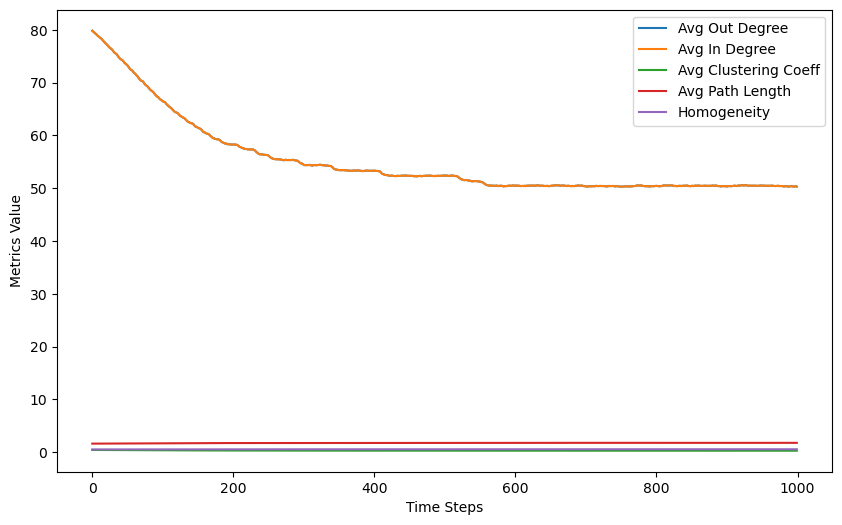

In [59]:
# Running the model
model = SocialNetworkModel(num_agents=200, initial_p=0.4, graph_type="random", interaction="targeted")
for i in range(1000):
    model.step()
    pos = nx.spring_layout(model.G)
    #if i // 50 == 0:
        #nx.draw(model.G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=10, font_color="black")
        #plt.show()
    print(i)

# Example of how to plot metrics
plt.figure(figsize=(10, 6))
plt.plot(model.data_collector["avg_out_degree"], label="Avg Out Degree")
plt.plot(model.data_collector["avg_in_degree"], label="Avg In Degree")
plt.plot(model.data_collector["avg_clustering_coeff"], label="Avg Clustering Coeff")
plt.plot(model.data_collector["avg_path_length"], label="Avg Path Length")
plt.plot(model.data_collector["homogeneity"], label="Homogeneity")
plt.xlabel("Time Steps")
plt.ylabel("Metrics Value")
plt.legend()
plt.show()

In [ ]:
# Running the model
model = SocialNetworkModel(num_agents=100, initial_p=0.6, graph_type="random", interaction="random")
for i in range(1000):
    model.step()
    pos = nx.spring_layout(model.G)
    #nx.draw(model.G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=10, font_color="black")
    #plt.show()

# Example of how to plot metrics
plt.figure(figsize=(10, 6))
plt.plot(model.data_collector["avg_out_degree"], label="Avg Out Degree")
plt.plot(model.data_collector["avg_in_degree"], label="Avg In Degree")
plt.plot(model.data_collector["avg_clustering_coeff"], label="Avg Clustering Coeff")
plt.plot(model.data_collector["avg_path_length"], label="Avg Path Length")
plt.plot(model.data_collector["homogeneity"], label="Homogeneity")
plt.xlabel("Time Steps")
plt.ylabel("Metrics Value")
plt.legend()
plt.show()